## RNN for Skyrmion trajectories prediction

**Imports**

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

**Read the data**

In [3]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11995,26.838018,9158.734705,799.0,10.0
11996,92.153535,8909.539660,799.0,11.0
11997,160.675052,8812.401110,799.0,12.0
11998,156.663224,8600.194927,799.0,13.0


**Particles used for training**


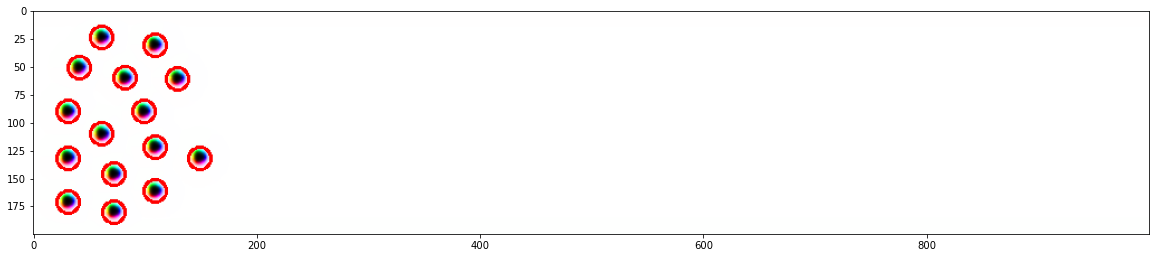

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 117.08it/s]


In [9]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data, directory)

# format data so that it is in the format (frame, next_frame)
frames = np.array(get_frames(data))

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

In [42]:
# split into train and test sets
train_size = int(len(frames) * 0.67)
test_size = len(frames) - train_size
train, test = frames[0:train_size,:], frames[train_size:len(frames),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [44]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [69]:
# choose a number of time steps
n_steps = 3
# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [70]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras import regularizers

In [87]:
# define model
model = Sequential()
model.add(SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(SimpleRNN(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

In [88]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=400)

Train on 533 samples, validate on 261 samples
Epoch 1/400
533/533 [==============================] - 0s 629us/step - loss: 1111.3613 - mse: 3688395.5000 - val_loss: 983.7843 - val_mse: 3336574.0000
Epoch 2/400
533/533 [==============================] - 0s 118us/step - loss: 212.4745 - mse: 239409.7812 - val_loss: 235.1720 - val_mse: 100137.6484
Epoch 3/400
533/533 [==============================] - 0s 108us/step - loss: 75.3330 - mse: 12584.0479 - val_loss: 169.5595 - val_mse: 43961.8398
Epoch 4/400
533/533 [==============================] - 0s 101us/step - loss: 48.7875 - mse: 4196.1387 - val_loss: 112.6008 - val_mse: 21197.7520
Epoch 5/400
533/533 [==============================] - 0s 99us/step - loss: 38.0516 - mse: 2507.6113 - val_loss: 91.7723 - val_mse: 12402.1104
Epoch 6/400
533/533 [==============================] - 0s 99us/step - loss: 41.0833 - mse: 2881.3660 - val_loss: 117.7103 - val_mse: 20751.1270
Epoch 7/400
533/533 [==============================] - 0s 94us/step - loss:

In [89]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[6135.2259593   149.77582725 6051.81894357   83.99639372 5909.44678511
   67.55963887 6024.48949717   96.68259447 6087.3341415    65.63742561
 5809.35471941  149.91847564 5943.35428604   82.57031826 5893.60916101
  124.89630567 6192.8686004   119.76828457 5930.59869104  158.45686008
 6202.44923468   68.840385   6026.37740046   47.47638467 5988.92726025
  168.68713902 5771.70215176  154.45541714 5859.54027521  172.80810539]
[6158.3213    158.484    5989.786     107.02604  5853.9717     66.88803
 6006.2905    116.029785 6080.0684     87.04661  5764.3667    157.63316
 5936.9165    101.66387  5891.337     100.89784  6182.984      75.145164
 5926.5557    157.52052  6178.968      71.58669  6040.1562     49.967415
 6006.829     169.13416  5736.2754    143.3551   5818.359     161.30423 ]


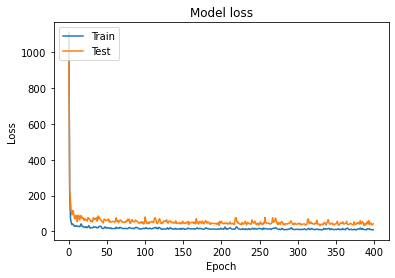

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()